### Procesamiento de Palabras

0. Agregar una columna que mide el porcentaje de inglés usado en el tweet  y ver con eso  cuántos son en inglés ( tweets que superan cierto threshold de inglés)
1. Diferenciar preguntas de afirmaciones (relacionar con el target)
2. Tweet “inutiles” (tweets sin palabras ingles, cosas raras)



In [84]:
#IMPORTS

import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys,os
%run ../datuslib.ipynb

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [85]:
N_df = pd.read_csv("../Data/train.csv")
N_df.text.isnull().sum() #no hay textos vacios

0

In [116]:
N_df['len_texts'] = N_df.text.map(lambda x: len(x))
N_df.describe()

,id,target,len_texts,english_percentage
count,7613.000000,7613.00000,7613.000000,7613.000000
mean,5441.934848,0.42966,101.161697,79.164917
std,3137.116090,0.49506,33.854073,14.047704
min,1.000000,0.00000,7.000000,0.000000
25%,2734.000000,0.00000,78.000000,70.370370
50%,5408.000000,0.00000,107.000000,80.000000
75%,8146.000000,1.00000,133.000000,90.000000
max,10873.000000,1.00000,157.000000,100.000000


In [87]:
N_df['english_percentage'] = N_df.text.map(lambda x: englishPercentage(x))

In [88]:
N_df

,id,keyword,location,text,target,len_texts,english_percentage
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,92.307692
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,57.142857
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,100.000000
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,85.714286
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,93.750000
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,85.714286
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,80.952381
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,53.846154
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,95.454545


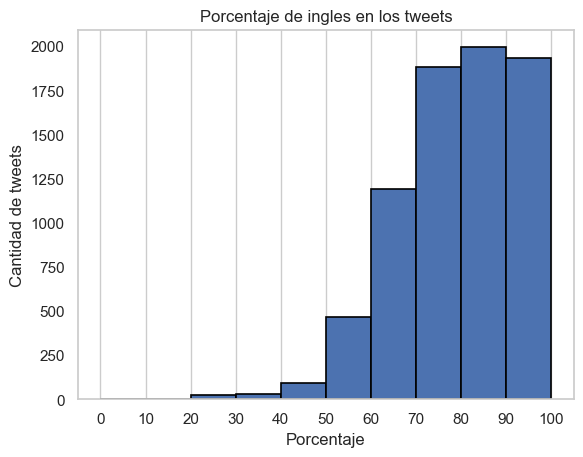

In [89]:
ax = plt.hist(N_df.english_percentage,color = 'b', bins = 10, edgecolor='black', linewidth=1.2)
plt.title("Porcentaje de ingles en los tweets", fontsize = 12)

tick = []
for i in range(0, 100+1, 10):
    tick.append(i)
plt.xticks(tick)

plt.xlabel('Porcentaje')
plt.ylabel('Cantidad de tweets')

plt.grid(which = 'major', axis = 'y')

In [90]:
N_df_falsos = N_df[N_df.target == 0]
N_df_verdaderos = N_df[N_df.target == 1]

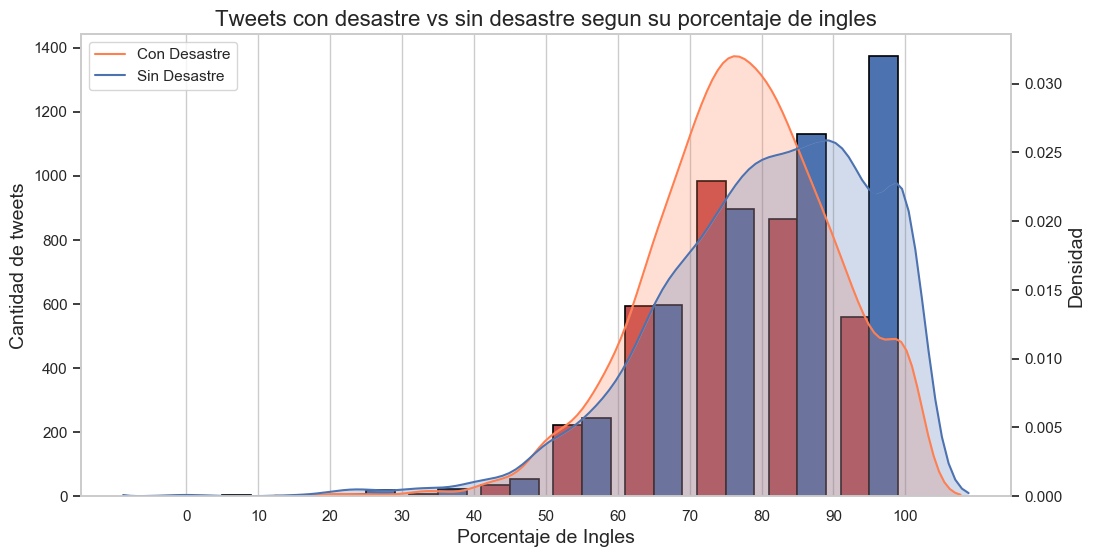

In [91]:
#Los tweets con un porcentaje de ingles mayor al 90% parecen tener mayor probabilidad de ser falsos.
fig, ax1 = plt.subplots()


ax1.set_xlabel("Porcentaje de Ingles", fontsize = 14)
ax1.set_ylabel("Cantidad de tweets", fontsize = 14)

ax1.hist([N_df_verdaderos.english_percentage, N_df_falsos.english_percentage], color = ['r', 'b'], bins = 10, edgecolor='black', linewidth=1.2)
ax1.tick_params(axis='y')
ax1.grid(which = 'major', axis = 'y')

ax2 = ax1.twinx()  
ax2.set_ylabel("Densidad", fontsize = 14)
ax2.grid(False)

sns.kdeplot(np.array(N_df_verdaderos.english_percentage), color = 'coral', shade = True, label = "Con Desastre")
sns.kdeplot(np.array(N_df_falsos.english_percentage), shade = True, label = "Sin Desastre", color = 'b')
plt.legend(loc='upper left')

fig.set_figheight(6)
fig.set_figwidth(12)

tick = []
for i in range(0, 101, 10):
    tick.append(i)

plt.xticks(tick)
plt.title("Tweets con desastre vs sin desastre segun su porcentaje de ingles", fontsize = 16)


plt.show()

In [92]:
''' Considerando que al menos un 50% del texto tiene que estar en ingles para que se considere que esta en ingles, podemos ver
cuantos textos vamos a rechazar, porque los textos que no esten en ingles no se podran analizar, ya que analizar textos
en todos los idiomas del mundo es sumamente complejo '''
N_df['tweets_en_ingles'] = N_df.english_percentage >= 50 #el threshold es del 50%, si la mitad del tweet tiene ingles, seguramente este en ingles.

In [93]:
N_df.tweets_en_ingles.value_counts() #Solo se descartan 150 tweets, menos de un 0.02% de los tweets

True     7463
False     150
Name: tweets_en_ingles, dtype: int64

In [ ]:
# 1. Diferenciar preguntas de afirmaciones (relacionar con el target) #Las que tienen pregunta ya son pocas, si agrego condiciones mas exigentes no tendra ningun sentido analizarlo

In [94]:
N_df['tiene_pregunta'] = N_df.text.map(lambda x: hasQuestion(x))  

In [129]:
N_df_preguntas_sin_desastre = N_df.copy()[N_df['tiene_pregunta'] & N_df.target == 0]
N_df_preguntas_con_desastre = N_df.copy()[N_df['tiene_pregunta'] & N_df.target == 1]

N_df_preguntas_con_desastre.len_texts.value_counts()

139    10
136     9
134     7
101     7
135     7
       ..
80      1
74      1
72      1
71      1
17      1
Name: len_texts, Length: 107, dtype: int64

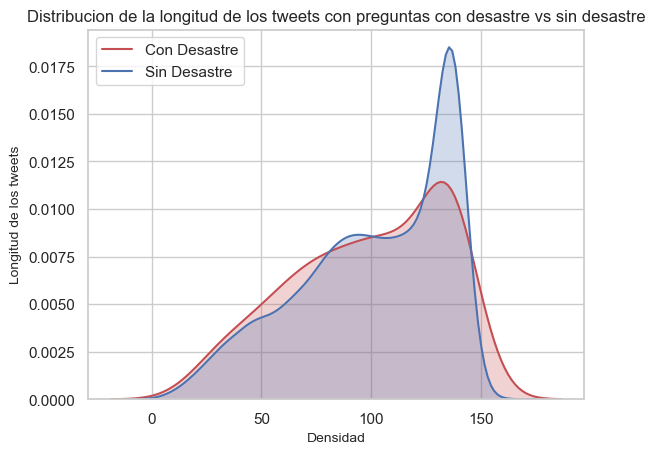

In [144]:
# Las preguntas mas largas tienen mas desastres? como se distrubuye la longitud de las preguntas con la veracidad del desastre?

sns.kdeplot(np.array(N_df_preguntas_con_desastre.len_texts), color = 'r', shade = True, label = "Con Desastre")
sns.kdeplot(np.array(N_df_preguntas_sin_desastre.len_texts), shade = True, label = "Sin Desastre", color = 'b')
plt.legend(loc='upper left')

plt.title("Distribucion de la longitud de los tweets con preguntas con desastre vs sin desastre", fontsize = 12)

plt.xlabel("Densidad", fontsize = 10)
plt.ylabel("Longitud de los tweets", fontsize = 10)
plt.show()

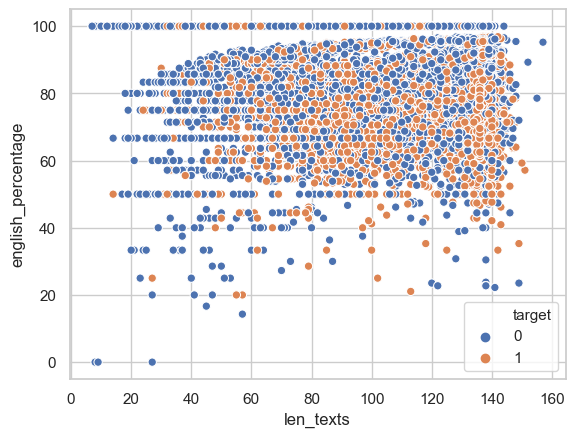

In [145]:
ax = sns.scatterplot(x="len_texts", y="english_percentage", hue="target", data=N_df)